<a href="https://colab.research.google.com/github/lucjalucja/analysis/blob/main/SoftAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

In [21]:
# Load data
data = pd.read_csv("Soft Skillet_ October Data Live - Activity Data vOct.csv")
add = pd.read_csv("outcome.csv")
data = pd.merge(data, add, on='Customer Account ID')
data.head()

,Activity ID,Date,Person,Call Connect,Pitch,Disposition,Customer Account ID,Outcome
0,01pElO8,9/12/2024,Owner,Connected,AI,No interest,10898,Loss
1,02cNE8F,9/3/2024,Manager,Connected,Operator,Deferred to Other Stakeholder,26600,Open
2,0498JpwY8S,9/6/2024,Owner,Connected,AI,Engaged,29419,Loss
3,06Q6UJH,9/9/2024,Manager,Connected,Operator,No Interest,97655,Loss
4,07IT4x0,9/5/2024,Manager,Connected,Smooth,No Interest,57549,Loss


In [8]:
# Filter out rows where 'person', 'pitch', and 'disposition' are NaN
filtered_data = data.dropna(subset=['Person', 'Pitch', 'Disposition'], how='all')
filtered_data.head()

,Activity ID,Date,Person,Call Connect,Pitch,Disposition,Customer Account ID,Outcome
0,01pElO8,9/12/2024,Owner,Connected,AI,No interest,10898,Loss
1,02cNE8F,9/3/2024,Manager,Connected,Operator,Deferred to Other Stakeholder,26600,Open
2,0498JpwY8S,9/6/2024,Owner,Connected,AI,Engaged,29419,Loss
3,06Q6UJH,9/9/2024,Manager,Connected,Operator,No Interest,97655,Loss
4,07IT4x0,9/5/2024,Manager,Connected,Smooth,No Interest,57549,Loss


In [9]:
# Group by 'Person' and 'Pitch' to count the number of successful dispositions
success_counts = filtered_data[filtered_data['Outcome'] == 'Win'].groupby(['Person', 'Pitch'])['Disposition'].count().reset_index(name='SuccessCount')

# Group by 'Person' and 'Pitch' to count the total number of dispositions
total_counts = filtered_data.groupby(['Person', 'Pitch'])['Disposition'].count().reset_index(name='TotalCount')

# Merge success and total counts, using 'outer' join to include all combinations
merged_counts = pd.merge(success_counts, total_counts, on=['Person', 'Pitch'], how='outer')

# Fill NaN values in 'SuccessCount' with 0 (for combinations with no successes)
merged_counts['SuccessCount'] = merged_counts['SuccessCount'].fillna(0)

# Calculate the success rate
merged_counts['SuccessRate'] = (merged_counts['SuccessCount'] / merged_counts['TotalCount']) * 100


print("Success Rates for all combinations:")
merged_counts

Success Rates for all combinations:


,Person,Pitch,SuccessCount,TotalCount,SuccessRate
0,Manager,AI,12,103,11.650485
1,Manager,Operator,6,196,3.061224
2,Manager,Smooth,5,143,3.496503
3,Owner,AI,13,68,19.117647
4,Owner,Operator,7,67,10.447761
5,Owner,Smooth,15,70,21.428571


In [10]:
# Install necessary libraries for transcription
!pip install pydub
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 52.9 MB/s eta 0:00:00


In [13]:
import os
import subprocess
from pydub import AudioSegment
import speech_recognition as sr

def transcribe_audio(file_path):
  """
  Transcribes an audio file using Google Speech Recognition.

  Args:
    file_path: The path to the audio file.

  Returns:
    The transcribed text, or None if transcription fails.
  """
  recognizer = sr.Recognizer()
  try:
    # Explicitly convert to WAV using pydub
    audio = AudioSegment.from_file(file_path)
    audio.export("temp.wav", format="wav")  # Export to a temporary WAV file

    with sr.AudioFile("temp.wav") as source:
      audio_data = recognizer.record(source)
      text = recognizer.recognize_google(audio_data)

    os.remove("temp.wav")  # Remove the temporary file
    return text

  except sr.UnknownValueError:
    print(f"Google Speech Recognition could not understand audio in {file_path}")
    return None
  except sr.RequestError as e:
    print(f"Could not request results from Google Speech Recognition service; {e}")
    return None
  except Exception as e:
    print(f"An error occurred: {e}")  # Catch and print other exceptions
    return None


def convert_mov_to_wav(mov_file_path):
    """Converts .mov file to .wav using ffmpeg"""
    wav_file_path = mov_file_path.replace(".mov", ".wav")
    try:
        subprocess.run(["ffmpeg", "-i", mov_file_path, wav_file_path], check=True)
        return wav_file_path
    except subprocess.CalledProcessError as e:
        print(f"Error converting .mov to .wav: {e}")
        return None

def process_files_in_directory(directory):
    """Processes all .mov and .mp3 files in a directory"""
    for filename in os.listdir(directory):
        if filename.endswith(".mov"):
            file_path = os.path.join(directory, filename)
            wav_file_path = convert_mov_to_wav(file_path)
            if wav_file_path:
                transcription = transcribe_audio(wav_file_path)
                if transcription:
                    output_file_path = file_path.replace(".mov", ".txt")
                    with open(output_file_path, "w") as f:
                        f.write(transcription)
        elif filename.endswith(".mp3"):
            file_path = os.path.join(directory, filename)
            transcription = transcribe_audio(file_path) # transcribe_audio directly for .mp3 files
            if transcription:
                output_file_path = file_path.replace(".mp3", ".txt")
                with open(output_file_path, "w") as f:
                    f.write(transcription)


directory_to_process = "/content/additional"  # path to directory with recordings
process_files_in_directory(directory_to_process)

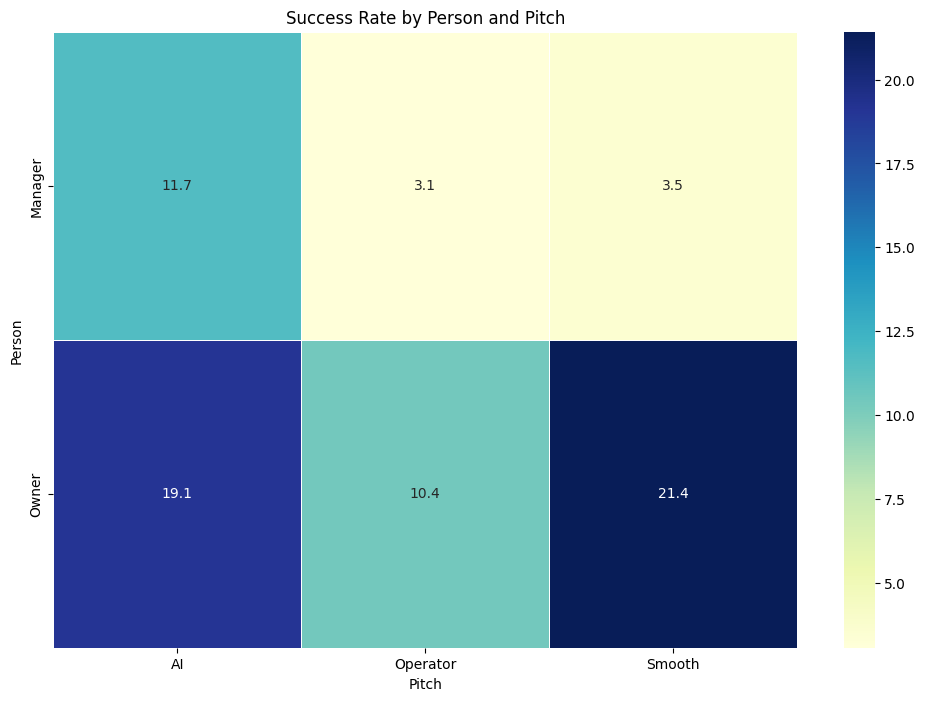

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# pivot table for plotting
pivot_table = merged_counts.pivot(index='Person', columns='Pitch', values='SuccessRate')

# heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Success Rate by Person and Pitch")
plt.xlabel("Pitch")
plt.ylabel("Person")
plt.show()

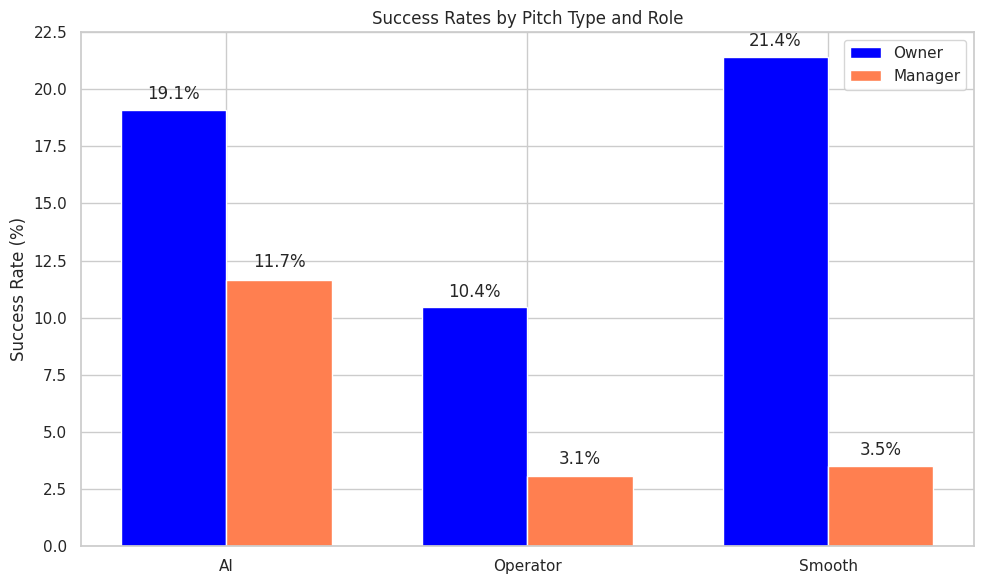

In [62]:
import numpy as np
import matplotlib.pyplot as plt

categories = pivot_table.columns  # Pitch types (AI, Smooth Revenue, Operator)
owner_success = pivot_table.loc['Owner'].values  # Owner success rates
manager_success = pivot_table.loc['Manager'].values  # Manager success rates

#  x positions for bars
x = np.arange(len(categories))
width = 0.35  # Width of bars

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, owner_success, width, label='Owner', color='blue')
bars2 = ax.bar(x + width/2, manager_success, width, label='Manager', color='coral')

# Adding labels, title, and customizations
ax.set_ylabel('Success Rate (%)')
ax.set_title('Success Rates by Pitch Type and Role')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Annotating the bars with success rates
for bars in [bars1, bars2]:
    for bar in bars:
        yval = round(bar.get_height(),1)  # Round the percentage to nearest integer
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval}%', ha='center')


plt.tight_layout()
plt.show()


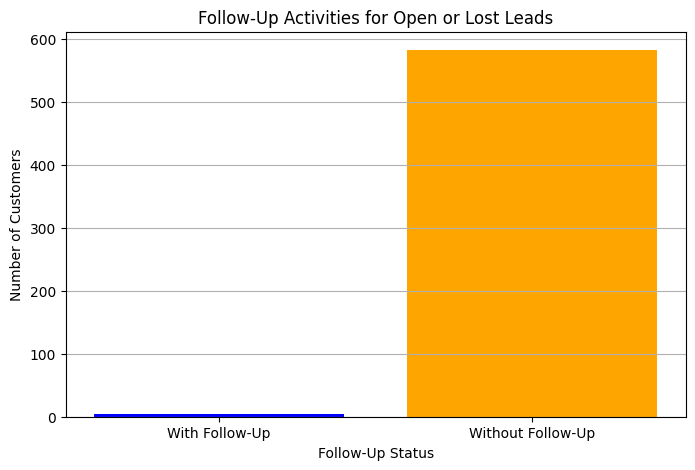

,Customer Account ID,Follow-Up Activity Count
0,10750,0
1,10898,0
2,11035,0
3,11104,0
4,11467,0
...,...,...
583,99689,0
584,99709,0
585,99813,0
586,99948,0


In [32]:

# Convert 'Date' column to datetime format for sorting and filtering purposes
activity_data['Date'] = pd.to_datetime(activity_data['Date'], errors='coerce')

# Filter accounts with open or lost status
filtered_accounts = account_data[account_data['Outcome'].str.contains('Open|Loss', case=False, na=False)]

# Create a list to store unique Customer Account IDs that are open or lost leads
open_lead_account_ids = filtered_accounts['Customer Account ID'].unique()

# Dictionary to store counts of follow-up activities for each open lead account
follow_up_activity_counts = {}
no_follow_up_activity_count = 0
follow_up_activity_count = 0

for account_id in open_lead_account_ids:
    # Filter all records for the current account ID
    account_activity = activity_data[activity_data['Customer Account ID'] == account_id].sort_values(by='Date')

    # Check if there are follow-up activities
    has_follow_up = len(account_activity) > 1  # If there is more than one activity, it's considered a follow-up

    if has_follow_up:
        follow_up_activity_count += 1
    else:
        no_follow_up_activity_count += 1

    follow_up_activity_counts[account_id] = len(account_activity) - 1 if has_follow_up else 0

# Convert dictionary to DataFrame for better representation
follow_up_activity_df = pd.DataFrame(list(follow_up_activity_counts.items()), columns=['Customer Account ID', 'Follow-Up Activity Count'])

# Plotting follow-up statistics for open or lost leads
labels = ['With Follow-Up', 'Without Follow-Up']
counts = [follow_up_activity_count, no_follow_up_activity_count]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, counts, color=['blue', 'orange'])
plt.title('Follow-Up Activities for Open or Lost Leads')
plt.xlabel('Follow-Up Status')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.show()

# Display follow-up activity details
from IPython.display import display
display(follow_up_activity_df)




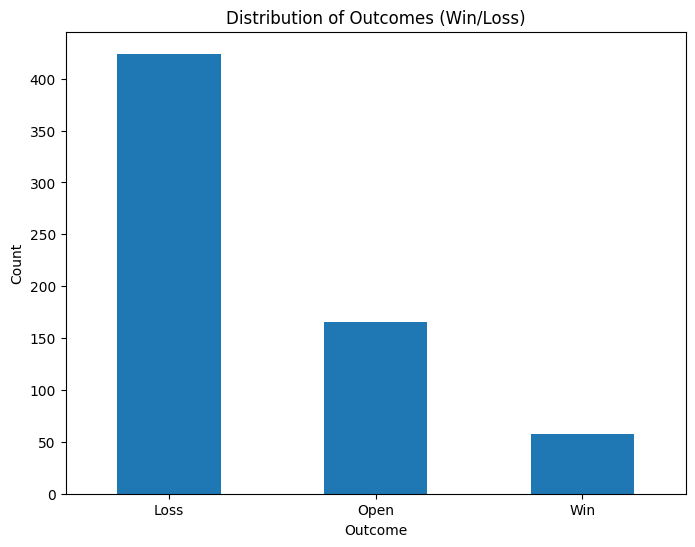

In [14]:

plt.figure(figsize=(8, 6))
filtered_data['Outcome'].value_counts().plot(kind='bar')
plt.title('Distribution of Outcomes (Win/Loss)')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


Check follow up with breakdown

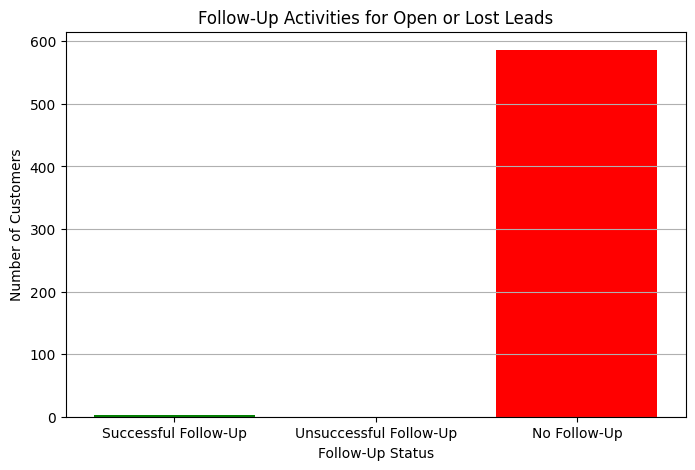

Successful follow-ups:  2
Unsuccessful follow-ups:  0
Missed calls without any follow-up:  586


In [56]:

# Filter accounts with open or lost status
filtered_accounts = account_data[account_data['Outcome'].str.contains('Open|Loss', case=False, na=False)]
open_lead_account_ids = filtered_accounts['Customer Account ID'].unique()

# Counters for successful, unsuccessful follow-ups, and no follow-ups
successful_follow_up_count = 0
unsuccessful_follow_up_count = 0
no_follow_up_count = 0

for account_id in open_lead_account_ids:
    # Filter all records for the current account ID, sort by date
    account_activity = activity_data[activity_data['Customer Account ID'] == account_id].sort_values(by='Date')

    missed_call_found = False
    successful_follow_up_found = False
    unsuccessful_follow_up_found = False

    for index, row in account_activity.iterrows():
        # Check if the activity is a missed call
        if row['Call Connect'] == 'No Answer':
            missed_call_found = True
        # Check for a successful follow-up (i.e., "Connected" call after missed call)
        elif missed_call_found and row['Call Connect'] == 'Connected':
            successful_follow_up_found = True
            break  # Stop after finding the first successful follow-up
        # Check if there is a follow-up, but it's not connected (unsuccessful)
        elif missed_call_found and row['Call Connect'] == 'No Answer':
            unsuccessful_follow_up_found = True

    # Update counters based on the outcome
    if successful_follow_up_found:
        successful_follow_up_count += 1
    elif unsuccessful_follow_up_found:
        unsuccessful_follow_up_count += 1
    else:
        no_follow_up_count += 1

# Plotting follow-up statistics for open or lost leads with three categories
labels = ['Successful Follow-Up', 'Unsuccessful Follow-Up', 'No Follow-Up']
counts = [successful_follow_up_count, unsuccessful_follow_up_count, no_follow_up_count]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, counts, color=['green', 'orange', 'red'])
plt.title('Follow-Up Activities for Open or Lost Leads')
plt.xlabel('Follow-Up Status')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.show()

# Display follow-up activity details
print("Successful follow-ups: ", successful_follow_up_count)
print("Unsuccessful follow-ups: ", unsuccessful_follow_up_count)
print("Missed calls without any follow-up: ", no_follow_up_count)

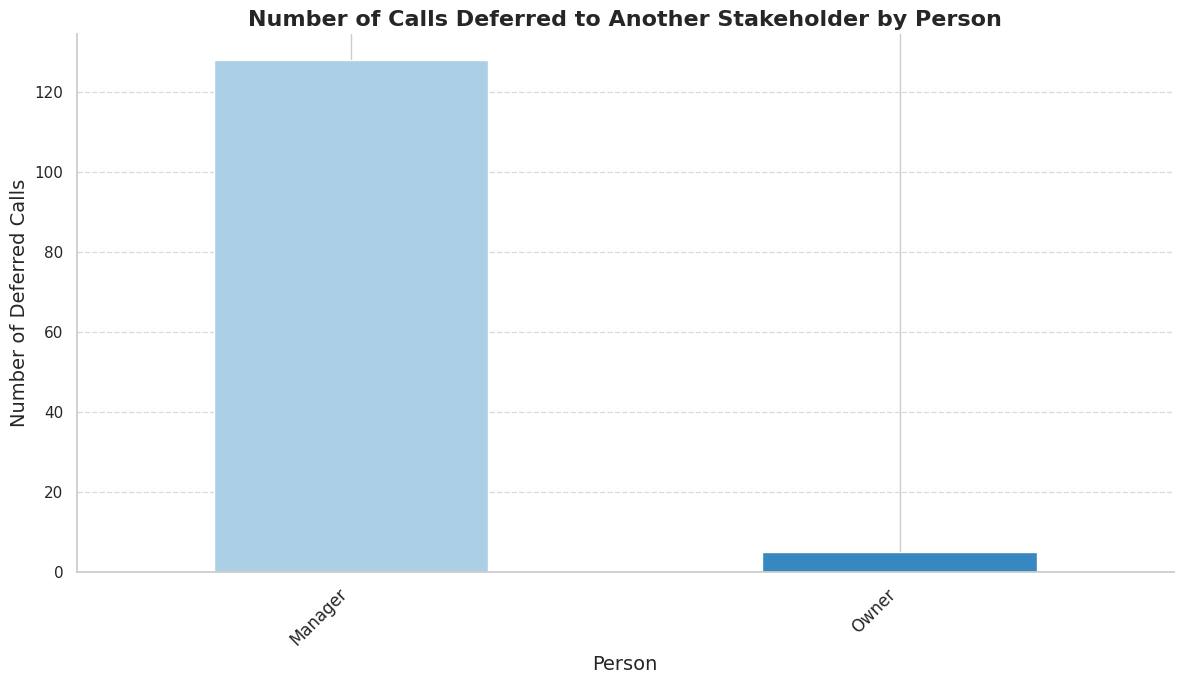

In [60]:

sns.set(style="whitegrid")

# Count of deferred calls grouped by 'Person' field
deferred_calls_by_person = deferred_calls.groupby('Person').size()

# Create a bar plot for this data
fig, ax = plt.subplots(figsize=(12, 7))
colors = sns.color_palette("Blues", len(deferred_calls_by_person))

# Plot with enhancements
deferred_calls_by_person.plot(kind='bar', color=colors, ax=ax)

# Adding titles and labels with formatting
plt.title('Number of Calls Deferred to Another Stakeholder by Person', fontsize=16, fontweight='bold')
plt.xlabel('Person', fontsize=14)
plt.ylabel('Number of Deferred Calls', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding gridlines for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Removing the spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


In [68]:
df_activity_data = pd.read_csv('Soft Skillet_ October Data Live - Activity Data vOct.csv')
df_account_data = pd.read_csv('outcome.csv')

# Define the interest dispositions, including 'Deferred'
interest_dispositions_expanded = ['Deferred to Other Stakeholder', 'Interested', 'Moving Forward', 'Deferred']

# Filter for engaged cases (where 'Call Connect' is 'Connected')
df_engaged = df_activity_data[df_activity_data['Call Connect'] == 'Connected']

# Filter for cases with initial interest based on the expanded disposition list
df_engaged_deferred_interest = df_engaged[df_engaged['Disposition'].isin(interest_dispositions_expanded)]

# Count the activities for each customer to check if they had follow-up
df_engaged_deferred_interest_counts = df_engaged_deferred_interest.groupby('Customer Account ID').size().reset_index(name='activity_count')

# Filter to keep only those with 1 activity (no follow-up)
df_engaged_deferred_no_follow_up = df_engaged_deferred_interest_counts[df_engaged_deferred_interest_counts['activity_count'] == 1]

# Create the filtered dataset with no follow-up cases
filtered_data = df_activity_data[df_activity_data['Customer Account ID'].isin(df_engaged_deferred_no_follow_up['Customer Account ID'])]

# Merge the activity data with the account data based on 'Customer Account ID' to bring in the outcome information
df_merged = pd.merge(filtered_data, df_account_data, on='Customer Account ID', how='left')

#  filter out the 'Win' and 'Loss' outcomes, keeping only 'Open' cases
df_filtered_open_cases = df_merged[df_merged['Outcome'] == 'Open']

# include only the cases with the desired dispositions (Engaged or Deferred)
df_final_filtered = df_filtered_open_cases[df_filtered_open_cases['Disposition'].isin(interest_dispositions_expanded)]

# Count the number of such cases
final_filtered_open_case_count = df_final_filtered['Customer Account ID'].nunique()

# Output the count of open cases
print(f'Number of open cases with initial interest and no follow-up: {final_filtered_open_case_count}')

df_final_filtered.to_csv('filtered_data_open_cases.csv', index=False)


Number of open cases with initial interest and no follow-up: 94
